In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize as sp_minimize
%matplotlib inline

In [2]:
class Model(object):
    def __init__(self):
        self.debug_level = 0 
        self.log_sqrt_2pi = np.log(np.sqrt(2*np.pi))
 
        self.set_score_function()
        self.plr_res = profile_likelihood_ratio_result()

        self.n_params = 2
        self.params_dict = dict([(str(p_num), p_num) for p_num in range(self.n_params)])
        self.initial_values = [1.]*self.n_params
        
        self.constraints = ()
        
        self.set_data(np.array([], dtype=float))
        
    def set_data(self, data):
        try:
            _ = (data + data)**2
            _ = _.sum()
        except:
            print '::: Data isnt good enought! Puting data=np.zeros(100)'
            data=np.zeros(100)
            
        if self.debug_level>0:
            print '::: Data type:', type(data)
            try:
                print '::: Data element dtype:', data.dtype
            except AttributeError:
                print '::: Data element has no dtype attribute'
                
        self.data = data
        self.n_data = len(data)
    

    def reset_constraints(self):
        self.constraints = ()
    def set_constraint(self, param_name='0', value=1.):
        param_num = self.params_dict[param_name]
        self.constraints += ({'type': 'eq', 'fun': lambda x : x[param_num] - value},)
        
    def set_score_function(self, function_type='m2_log_likelihood_gaus'):
        if function_type=='m2_log_likelihood_gaus':
            self.n_params = 2
            self.initial_values = [1.]*self.n_params
            self.params_dict = {'mu': 0, 'sigma': 1}
            self.score_function = self.m2_log_likelihood_gaus
        else:
            print '::: Unknow function type setting f(x) = x.sum()'
            self.score_function = lambda x : x.sum()
            
    def m2_log_likelihood_gaus(self, params):
        ## params = [mu, sigma]
        f1 = 2 * self.n_data * ( np.log(params[1]) + self.log_sqrt_2pi)
        f2_vect = (self.data - params[0])**2 / params[1]**2
        f2 = f2_vect.sum()
        return f1 + f2
    
    def minimize(self):
        if self.debug_level>0:
            print '-'*90
            print '::: initial values:', self.initial_values
            print '::: constraints:', self.constraints
    
        res = sp_minimize(self, self.initial_values, constraints=self.constraints)

        if self.debug_level>0:
            print res
        return res
        
    def __call__(self, params):
        return self.score_function(params)

    def profile_likelihood_ratio_curve(self):
        ### options
        param_of_interest = 'mu'
        poi_n_steps = 50
        poi_param_num = self.params_dict[param_of_interest]
        
        ### create object to store results
        #plr_res = profile_likelihood_ratio_result()
        self.plr_res.poi_name = param_of_interest
        
        ### get MLE
        self.reset_constraints()
        res_hat = self.minimize() 
        if not res_hat.success:
            print '::: Minimization Failed!!!!!!'
        self.plr_res.poi_mle = res_hat.x[poi_param_num]
        self.plr_res.score_poi_mle = res_hat.fun
        
        ### set poi range for PLR from Hessian 
        ### delta_poi = sqrt(2*H^-1) for -2 ln(L)
        ### -2*log(PLR) as a chi2_1 distribution (chi2=1 => 68%, chi2=4 => 95%)
        delta_poi = np.sqrt(2*res_hat.hess_inv[poi_param_num, poi_param_num])
        n_sigma = 3.
        poi_start =  self.plr_res.poi_mle - n_sigma * delta_poi 
        poi_stop = self.plr_res.poi_mle + n_sigma * delta_poi 
        poi_range = np.linspace(poi_start, poi_stop, poi_n_steps, endpoint=True)
        
        ### Estimate L around MLE
        for i, poi in enumerate(poi_range):
            self.reset_constraints()
            self.set_constraint(param_of_interest, poi)
            res = self.minimize()
            if not res.success:
                print '::: Minimization Failed!!!!!!'
            self.plr_res.pois.append(poi)
            self.plr_res.scores_poi.append(res.fun)

        self.plr_res.compute_plr()

        return self.plr_res
    
class profile_likelihood_ratio_result(object):
    def __init__(self):
        self.poi_name = 'mu'
        self.poi_mle = 0.
        self.score_poi_mle = 100.
        self.pois = []
        self.scores_poi = []
    def compute_plr(self):
        self.plr = [score_poi - self.score_poi_mle for score_poi in self.scores_poi]

        

In [3]:
n_data = 10000
mu = 0.
sigma = 1.
data = np.random.normal(mu, sigma, n_data)

In [4]:
model = Model()

model.debug_level = 0

model.set_data(data)
model.set_score_function('m2_log_likelihood_gaus')

In [5]:
res = model.profile_likelihood_ratio_curve()

/home/renaud/anaconda2/envs/main_env/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in log


In [6]:
## need to use deg=3 and filter values outside x range
def quadratic_intersections(p, q):
    """Given two quadratics p and q, determines the points of intersection"""
    x = np.roots(np.asarray(p) - np.asarray(q))
    y = np.polyval(p, x)
    return x, y

poly = np.polyfit(res.pois, res.plr, deg=2)
y_int  = np.polyval(poly, res.pois)
ix_1 = quadratic_intersections(poly, [ 0, 0, 1])
ix_4 = quadratic_intersections(poly, [ 0, 0, 4])
print ix_1
print ix_4

(array([ 0.01317972, -0.00660092]), array([ 1.,  1.]))
(array([ 0.02307281, -0.01649401]), array([ 4.,  4.]))


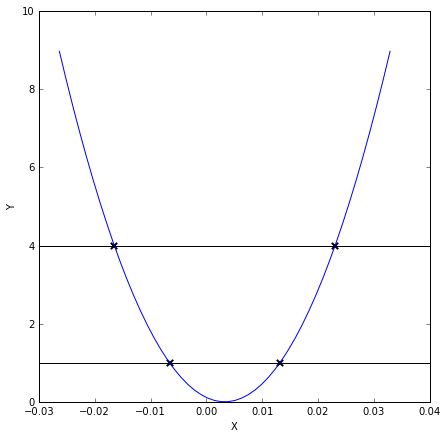

In [7]:
plt.figure(figsize = (7,7))
plt.subplot(111)
plt.plot(res.pois, res.plr)
s1 = plt.axhline(1, linewidth=1, color='k')
s4 = plt.axhline(4, linewidth=1, color='k')
plt.scatter(*ix_1, marker='x', color='black', s=40, linewidth=2)
plt.scatter(*ix_4, marker='x', color='black', s=40, linewidth=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(bottom=0)
plt.show()